# IntervalScheduler
Version 2 for debugging

In [1]:
import sys
import os


# Make sure the root or 03_optimization folder is in the path
sys.path.append(os.path.abspath('../'))   # adjust path if needed
sys.path.append(os.path.abspath('../..'))   # adjust path if needed
#print (sys.path)
print("Current Python Path:", sys.path)

Current Python Path: ['C:\\Users\\fh6281\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\fh6281\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\fh6281\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\fh6281\\AppData\\Local\\Programs\\Python\\Python312', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\venv', '', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\venv\\Lib\\site-packages', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\venv\\Lib\\site-packages\\win32', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\03_optimization', 'c:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate']


In [2]:
from optimization.base import BaseOptimizer
from utils import simpsons_rule, cdf_formula, pdf_formula, cdf_formula_numpy
from input_manager.price_manager import PriceManager

import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

import matplotlib.dates as mdates
import plotly.express as px
from scipy.optimize import fsolve
import numpy as np

In [3]:
def get_quantile_widths(cdf, cdf_weights, probabilities_of_interval):
    quantile_values = {}
    samples = np.linspace(-8, 8, 10000)  # TODO: Code dynamic bounds

    for t in cdf_weights.keys():
        weights = cdf_weights[t]
        quantile_values[t] = {}

        # try some values and remember the values right before and after the quantile probabilities
        for prob in probabilities_of_interval:
            for i, sample in enumerate(samples):
                cdf_val = cdf(sample, *weights)
                if cdf_val >= prob:
                    quantile_values[t][prob] = [i-1, samples[i-1], cdf(samples[i-1], *weights), i, sample, cdf_val]
                    break


    # For now, only take the first value for the calculation of the width
    quantile_approximations = {}
    for t, values in quantile_values.items():
        quantile_approximations[t] = values[0.75][1] - values[0.25][1]  # Take the value just before the quantile

    return quantile_approximations

def get_pb_widths(battery_size, quantile_widths):
    #scale_factor = battery_size / quantile_widths.sum()
    scale_factor = battery_size / sum(quantile_widths.values())
    #pb_widths = quantile_widths * scale_factor
    pb_widths = {t: w * scale_factor for t, w in quantile_widths.items()}
    # transform to series
    pb_widths = pd.Series(pb_widths, name='pb_width')
    return pb_widths

In [4]:
class IntervalOptimizer(BaseOptimizer):


    def __init__(self, battery_cfg: dict, mpc_freq: int, gt_freq: int, prices, param_assumption: str = None):
        super().__init__(battery_cfg=battery_cfg, mpc_freq=mpc_freq, gt_freq=gt_freq, prices=prices, param_assumption=param_assumption) # only necessary if this class has its own init method


        self.cdf = cdf_formula(self.param_assumption)
        self.pdf = pdf_formula(self.param_assumption)
        #self.c_buy_long = None  # TODO:  Initialize once in __init__ in base class => Here only take the needed values 
        #self.c_sell_long = None  # TODO: Initialize once in __init__ in base class => Here only take the needed values 




    def _build_model(self):

        self._define_sets()

        self._define_parameters()

        self._define_decision_variables()

        self._define_constraints()

        self._define_objective_function()


    
    def _define_sets(self):

        self.model.time = pyo.Set(initialize=self.time_index)
        self.model.time_e = pyo.Set(initialize=self.time_index.append(pd.Index([self.time_index[-1] + self.time_index.freq])))
        self.model.time_e0 = pyo.Set(initialize=self.time_index.to_list()[:1])

    def _define_parameters(self):
        self.model.e0 = pyo.Param(self.model.time_e0, initialize=self.soe_initial)  # TODO: self.soe_initial ok?
        self.model.pdf_weights = pyo.Param(self.model.time, initialize=self.pdf_weights, domain=pyo.Any) 

        # TODO: Add dynamic bounds for pdf integration


        # Interval width
        quantile_widths = get_quantile_widths(self.cdf, self.pdf_weights, [0.25, 0.75])
        pb_widths = get_pb_widths(self.cap_max - self.cap_min, quantile_widths)
        print("Pb_widths:", pb_widths)
        #print("Sum of pb_widths:", pb_widths.values())
        print("Sum of pb_widths:", sum(pb_widths))
        self.model.pb_width = pyo.Param(self.model.time, initialize=pb_widths, domain=pyo.NonNegativeReals)


    def _define_decision_variables(self): 
        # Battery Power
        self.model.pb_exp = pyo.Var(self.model.time, domain=pyo.Reals)
        self.model.y_low = pyo.Var(self.model.time, domain=pyo.Reals)
        self.model.y_high = pyo.Var(self.model.time, domain=pyo.Reals)

        # Battery Energy
        self.model.e_exp = pyo.Var(self.model.time_e, domain=pyo.Reals)
        self.model.e_min = pyo.Var(self.model.time_e, domain=pyo.Reals)
        self.model.e_max = pyo.Var(self.model.time_e, domain=pyo.Reals)

        # Complementary variables
        self.model.y_low_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.y_low_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.y_high_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.y_high_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.pb_exp_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.pb_exp_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)

        # Probabilities of being out of bounds [y_low, y_high]
        self.model.prob_low = pyo.Var(self.model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))
        self.model.prob_high = pyo.Var(self.model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))

        # Expected grid power
        self.model.pg_exp_buy = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.pg_exp_sell = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)





    def _define_constraints(self):
        # Battery Evolution
        def constr_e_min(model, t):
            ''' e_min[t] = e_min[t-1] - y_high_ch[t-1] * dt * eta_ch - y_high_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_min[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_min[t] == model.e_min[t_prev] - model.y_high_ch[t_prev] * self.t_inc * self.eta_ch - model.y_high_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_min = pyo.Constraint(self.model.time_e, rule=constr_e_min)


        def constr_e_max(model, t):
            ''' e_max[t] = e_max[t-1] - y_low_ch[t-1] * dt * eta_ch - y_low_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_max[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_max[t] == model.e_max[t_prev] - model.y_low_ch[t_prev] * self.t_inc * self.eta_ch - model.y_low_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_max = pyo.Constraint(self.model.time_e, rule=constr_e_max)



        def constr_e_exp(model, t):
            ''' e_exp[t] = e_exp[t-1] - pb_exp_ch[t-1] * dt * eta_ch - pb_exp_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_exp[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_exp[t] == model.e_exp[t_prev] - model.pb_exp_ch[t_prev] * self.t_inc * self.eta_ch - model.pb_exp_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_exp = pyo.Constraint(self.model.time_e, rule=constr_e_exp)




        # Battery Limits
        def constr_e_min_limit(model, t):
            ''' e_min[t] >= capacity_min '''
            return model.e_min[t] >= self.cap_min
        self.model.constr_e_min_limit = pyo.Constraint(self.model.time_e, rule=constr_e_min_limit)

        def constr_e_max_limit(model, t):
            ''' e_max[t] <= capacity_max '''
            return model.e_max[t] <= self.cap_max
        self.model.constr_e_max_limit = pyo.Constraint(self.model.time_e, rule=constr_e_max_limit)

        def constr_y_low_limit(model, t):
            ''' y_low[t] >= power_min'''
            return model.y_low[t] >= self.pb_min
        self.model.constr_y_low_limit = pyo.Constraint(self.model.time, rule=constr_y_low_limit)

        def constr_y_high_limit(model, t):
            ''' y_high[t] <= power_max'''
            return model.y_high[t] <= self.pb_max
        self.model.constr_y_high_limit = pyo.Constraint(self.model.time, rule=constr_y_high_limit)




        # Complementary Constraints
        def constr_y_low_split(model, t):
            ''' y_low[t] = y_low_ch[t] + y_low_dis[t] '''
            return model.y_low[t] == model.y_low_ch[t] + model.y_low_dis[t]
        self.model.constr_y_low_split = pyo.Constraint(self.model.time, rule=constr_y_low_split)

        def constr_y_low_relaxation(model, t):
            ''' -1e-8 <= y_low_ch[t] * y_low_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.y_low_ch[t] * model.y_low_dis[t], 0)
        self.model.constr_y_low_relaxation = pyo.Constraint(self.model.time, rule=constr_y_low_relaxation)

        def constr_y_high_split(model, t):
            ''' y_high[t] = y_high_ch[t] + y_high_dis[t] '''
            return model.y_high[t] == model.y_high_ch[t] + model.y_high_dis[t]
        self.model.constr_y_high_split = pyo.Constraint(self.model.time, rule=constr_y_high_split)

        def constr_y_high_relaxation(model, t):
            ''' -1e-8 <= y_high_ch[t] * y_high_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.y_high_ch[t] * model.y_high_dis[t], 0)
        self.model.constr_y_high_relaxation = pyo.Constraint(self.model.time, rule=constr_y_high_relaxation)

        def constr_pb_exp_split(model, t):
            ''' pb_exp[t] = pb_exp_ch[t] + pb_exp_dis[t] '''
            return model.pb_exp[t] == model.pb_exp_ch[t] + model.pb_exp_dis[t]
        self.model.constr_pb_exp_split = pyo.Constraint(self.model.time, rule=constr_pb_exp_split)

        def constr_pb_exp_relaxation(model, t):
            ''' -1e-8 <= pb_exp_ch[t] * pb_exp_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.pb_exp_ch[t] * model.pb_exp_dis[t], 0)
        self.model.constr_pb_exp_relaxation = pyo.Constraint(self.model.time, rule=constr_pb_exp_relaxation)



        # Charging / Discharging Constraints
        def constr_y_low_ch(model, t):
            ''' y_low_ch[t] <= 0 '''
            return model.y_low_ch[t] <= 0
        self.model.constr_y_low_ch = pyo.Constraint(self.model.time, rule=constr_y_low_ch)

        def constr_y_low_dis(model, t):
            ''' y_low_dis[t] >= 0 '''
            return model.y_low_dis[t] >= 0
        self.model.constr_y_low_dis = pyo.Constraint(self.model.time, rule=constr_y_low_dis)

        def constr_y_high_ch(model, t):
            ''' y_high_ch[t] <= 0 '''
            return model.y_high_ch[t] <= 0
        self.model.constr_y_high_ch = pyo.Constraint(self.model.time, rule=constr_y_high_ch)

        def constr_y_high_dis(model, t):
            ''' y_high_dis[t] >= 0 '''
            return model.y_high_dis[t] >= 0
        self.model.constr_y_high_dis = pyo.Constraint(self.model.time, rule=constr_y_high_dis)

        def constr_pb_exp_ch(model, t):
            ''' pb_exp_ch[t] <= 0 '''
            return model.pb_exp_ch[t] <= 0
        self.model.constr_pb_exp_ch = pyo.Constraint(self.model.time, rule=constr_pb_exp_ch)

        def constr_pb_exp_dis(model, t):
            ''' pb_exp_dis[t] >= 0 '''
            return model.pb_exp_dis[t] >= 0
        self.model.constr_pb_exp_dis = pyo.Constraint(self.model.time, rule=constr_pb_exp_dis)


        # Order of y_low and y_high
        def constr_y_order(model, t):
            ''' y_low[t] <= y_high[t] '''
            return model.y_low[t] <= model.y_high[t]
        self.model.constr_y_order = pyo.Constraint(self.model.time, rule=constr_y_order) 

        # TESTING ONLY       
        # def constr_y_orderTESTING(model, t):
        #     ''' y_low[t] <= y_high[t] '''
        #     return model.y_low[t] == -0.3
        # self.model.constr_y_orderTESTING = pyo.Constraint(self.model.time, rule=constr_y_orderTESTING)

        # End of Horizon Constraints
        # Ensure that e_max is at self.cap_max at the end of the horizon
        # def constr_e_max_end(model):
        #     ''' e_max[last] = capacity_max '''
        #     return model.e_max[model.time_e.last()] == self.cap_max
        # self.model.constr_e_max_end = pyo.Constraint(rule=constr_e_max_end)
        # def constr_e_min_end(model):
        #     ''' e_min[last] = capacity_min '''
        #     return model.e_min[model.time_e.last()] == self.cap_min
        # self.model.constr_e_min_end = pyo.Constraint(rule=constr_e_min_end)


        # Tryout: Fix the difference between y_low and y_high to the width of the interval
        def constr_y_width(model, t):
            ''' y_high[t] - y_low[t] = pb_width[t] '''
            return model.y_high[t] - model.y_low[t] == model.pb_width[t]
        self.model.constr_y_width = pyo.Constraint(self.model.time, rule=constr_y_width)




        # Probabilities of not being fully covered by the battery
        def constr_prob_low(model, t):
            ''' prob_low[t] = CDF[t](y_low[t]) '''
            return model.prob_low[t] == self.cdf(model.y_low[t], *model.pdf_weights[t])
        self.model.constr_prob_low = pyo.Constraint(self.model.time, rule=constr_prob_low)

        def constr_prob_high(model, t):
            ''' prob_high[t] = 1 - CDF[t](y_high[t]) '''
            return model.prob_high[t] == 1 - self.cdf(model.y_high[t], *model.pdf_weights[t])
        self.model.constr_prob_high = pyo.Constraint(self.model.time, rule=constr_prob_high)




        # Expected Powers
        def constr_pb_exp(model, t):
            ''' pb_exp[t] = prob_low[t] * y_low[t] + prob_high[t] * y_high[t] + INTEGRAL[z*pdf(weights[t], z)] bounds=[y_low[t], y_high[t]] '''
            return model.pb_exp[t] == model.prob_low[t] * model.y_low[t] + model.prob_high[t] * model.y_high[t] + simpsons_rule(model.y_low[t], model.y_high[t], n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=0) # TODO: Adjust parameters
        self.model.constr_pb_exp = pyo.Constraint(self.model.time, rule=constr_pb_exp)


        def constr_pg_exp_sell(model, t):
            ''' pg_exp_sell[t] = INTEGRAL[z*pdf(weights[t], z+y_low[t])] bounds=[-inf, 0]'''  # TODO: Maybe use historical minimum as integration bound? Does that cause issues since the pdf tails might be too long?
            return model.pg_exp_sell[t] == simpsons_rule(self.XXX_low_bound, 0, n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=model.y_low[t])  # TODO: Code dynamic bounds
        self.model.constr_pg_exp_sell = pyo.Constraint(self.model.time, rule=constr_pg_exp_sell)

        def constr_pg_exp_buy(model, t):
            ''' pg_exp_buy[t] = INTEGRAL[z*pdf(weights[t], z+y_high[t])] bounds=[0, inf]'''  # TODO: Maybe use historical maximum as integration bound? Does that cause issues since the pdf tails might be too long?
            return model.pg_exp_buy[t] == simpsons_rule(0, self.XXX_high_bound, n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=model.y_high[t])  # TODO: Code dynamic bounds
        self.model.constr_pg_exp_buy = pyo.Constraint(self.model.time, rule=constr_pg_exp_buy)



    def _define_objective_function(self):
        def objective(model):
            '''' Minimize the expected costs associated with the grid exchange. To discourage a total discharge
                of the battery, we reward the expected battery energy at the end of the horizon. '''
            sum_costs = sum(
                + self.c_sell[t] * model.pg_exp_sell[t]
                + self.c_buy[t] * model.pg_exp_buy[t]
                for t in model.time
            ) 
            costs_soe = 0.0 #- 0.08 * model.e_exp[model.time_e.last()]
            #costs_soe = - 0.2 * model.e_exp[model.time_e.last()]
            return sum_costs + costs_soe
        self.model.objective = pyo.Objective(rule=objective, sense=pyo.minimize)


    
    def solve(self):
        solver = pyo.SolverFactory('ipopt')
        solver.options['max_iter'] = 5000
        result = solver.solve(self.model, tee=True)
        return result
    

    def optimize(self, t_now: pd.Timestamp, fc_slice: pd.DataFrame) -> dict:

        #print("soe_now:", self.soe_now)

        self.fc_slice = fc_slice
        #print("fc_slice:", self.fc_slice)
        self.fc_slice.index = pd.DatetimeIndex(self.fc_slice.index.get_level_values('timestamp'), freq=str(self.mpc_freq) + 'min')
        self.time_index = fc_slice.index

        self.pdf_weights = fc_slice.apply(lambda row: row.tolist(), axis=1)



        self.XXX_low_bound = -15.0  # TODO: Code dynamic bounds
        self.XXX_high_bound = 15.0  # TODO: Code dynamic bounds

        self.c_buy = self.c_buy_long[self.time_index]  # TODO: Take the needed values from self.c_buy_long based on the time_index
        self.c_sell = self.c_sell_long[self.time_index]  # TODO: Get vals from self.c_sell_long

        #print("self.c_buy:", self.c_buy)

        self.model = pyo.ConcreteModel()

        self._build_model()

        result = self.solve()

        pb_low = [pyo.value(self.model.y_low[t]) for t in self.model.time]
        #pb_low = {t: pyo.value(model.y_low[t]) for t in model.time}
        pb_high = [pyo.value(self.model.y_high[t]) for t in self.model.time]

        decision = {
            'pb_low': pb_low[0],
            'pb_high': pb_high[0]
        }

        # TODO: Need to log all the results somewhere so that we cann see what the schedule is at a certain time.

        return decision


    def update_soe(self, t_now, decision, gt):
        

        # decision is a dict containing the actions pb_low and pb_high
        pb_low = decision.get('pb_low')
        pb_high = decision.get('pb_high')

        # If gt is lower than pb_low, we execute pb_low
        if gt <= pb_low:
            pb_now = pb_low
        
        # If gt is higher than pb_high, we execute pb_high
        elif gt >= pb_high:
            pb_now = pb_high
        
        # If gt is between pb_low and pb_high, we execute gt 
        else:
            pb_now = gt


        # Update the soe
        if pb_now <= 0:  # Charging
            eta = self.eta_ch
        elif pb_now > 0:  # Discharging
            eta = 1 / self.eta_dis

        pg_now = gt - pb_now  # Grid Power
        soe_new = self.soe_now - pb_now * self.gt_inc * eta

        #if soe_new > self.cap_max or soe_new < self.cap_min:
        #    raise ValueError(f"State of energy out of bounds for IntervalOptimizer: {soe_new} kWh at {t_now}. Expected bounds: [{self.cap_min}, {self.cap_max}] kWh.")
        

        self.results_realization[t_now] = {
            'timestamp': t_now,
            'action': pb_now,       # Power setpoint for the battery at t_now
            'pb_low': pb_low,   # Power setpoint for the battery at t_now
            'pb_high': pb_high, # Power setpoint for the battery at t_now
            'pg': pg_now,           # Grid power after applying the action
            'gt': gt,               # Ground truth at t_now
            'soe_now': self.soe_now,  # Current state of energy before applying the action
            'soe_new': soe_new      # New state of energy after applying the action
        }


        self.soe_now = soe_new
        return soe_new

In [44]:
config = {
    "run_name": "Test Experiment",

    "forecasts": {
        "model": "AutoKANHOURLYTEST",
        "fc_creation_time": "2025-07-25T14:18:05+00:00",
        "parametric_assumption": "sum2gaussian",
        "fc_update_freq": 60
    },


    "optimization": {
        "buildings": ["SFH3"],
        "models": ["interval"],
        "start_time": "2020-05-13T07:00:00+00:00",
        "end_time": "2020-05-13T23:00:00+00:00",
        "gt_freq": 1,
        "mpc_update_freq": [60],
        "mpc_horizon": 24,
        "prices": "const_prices_testing.csv"
    },


    "battery": {
        "capacity_min": 0.0,
        "capacity_max": 8.0,
        "power_min": -2.0,
        "power_max": 2.0,
        "charge_efficiency": 0.95,
        "discharge_efficiency": 0.95,

        "soe_initial": 4.0
    }
}

In [45]:
#optimizer = OptClass(battery_cfg=config['battery'], mpc_freq=mpc_freq, gt_freq=gt_delta, param_assumption=config['forecasts']['parametric_assumption'], prices=prices)
mpc_freq = config['optimization']['mpc_update_freq'][0]  # Assuming mpc_update_freq is a list with one element
gt_delta = config['optimization']['gt_freq']  # Assuming gt_freq is a single value

start_time = pd.Timestamp(config['optimization']['start_time'])

#prices_path = 'const_prices_testing.csv'
#prices_path = 'tou_import_export.csv'
prices_path = 'electricity_price_estimation.csv'

price_manager = PriceManager(prices_path, full_path=True)  # Assuming the path is correct and the file exists
prices = price_manager.get_prices(mpc_freq)

In [46]:
#fc_full = pd.read_csv('C:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\02_forecast\\storage_param_fc\\file_fc_parametric_AutoKANHOURLYCONST_SFH3_2025-07-25_14-18-05_freq60.csv')
fc_full = pd.read_csv('C:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\02_forecast\\storage_param_fc\\file_fc_parametric_AutoKANHOURLYTEST_SFH3_2025-07-25_14-18-05_freq60.csv')

fc_day = fc_full[pd.to_datetime(fc_full['time_fc_created']) == start_time]
fc_day = fc_day.drop(columns=['time_fc_created'])

# get a fc slice that begins at the same time and has a length of mpc_horizon
fc_slice = fc_day.iloc[:config['optimization']['mpc_horizon']].copy()
fc_slice.set_index('timestamp', inplace=True)

# Remove duplicate timestamps to ensure a regular frequency
fc_slice = fc_slice[~fc_slice.index.duplicated(keep='first')]

# set freq to the mpc_freq
fc_slice.index = pd.DatetimeIndex(fc_slice.index, freq=str(mpc_freq) + 'min')

# divide the std by 1000 to transform to kWh
fc_slice['std1'] = fc_slice['std1'] / 1000
fc_slice['std2'] = fc_slice['std2'] / 1000
fc_slice['mu1'] = fc_slice['mu1'] / 1000
fc_slice['mu2'] = fc_slice['mu2'] / 1000
fc_slice

,w1,mu1,std1,w2,mu2,std2
timestamp,,,,,,
2020-05-13 07:00:00+00:00,0.756350,-2.375438,0.548785,0.243650,-1.695409,1.342787
2020-05-13 08:00:00+00:00,0.690471,-3.010483,0.865370,0.309529,-2.047012,2.009814
2020-05-13 09:00:00+00:00,0.385358,-1.993395,1.530925,0.614642,-3.758854,1.148588
2020-05-13 10:00:00+00:00,0.399666,-1.946797,1.892568,0.600334,-3.840734,1.218995
2020-05-13 11:00:00+00:00,0.613289,-3.931818,1.368660,0.386711,-1.962516,1.637050
2020-05-13 12:00:00+00:00,0.407103,-1.356013,1.451290,0.592897,-3.554710,1.172658
2020-05-13 13:00:00+00:00,0.583640,-2.731998,1.153542,0.416360,-0.809824,1.493097
2020-05-13 14:00:00+00:00,0.528124,-1.810119,0.876568,0.471876,-0.121730,1.390498
2020-05-13 15:00:00+00:00,0.722692,-0.618405,0.692223,0.277308,0.256425,1.559742


In [47]:
# filter the prices to have the same index as fc_slice
prices = prices[prices.index.isin(fc_slice.index)]
# get the average of the prices
avg_price = prices.mean()
print("Average Price Import:", avg_price['import_price'], "   Average Price Export:", avg_price['export_price'])
total_mean_price = round(avg_price.mean(), 4)
print("Total Mean Price:", total_mean_price)
prices

Average Price Import: 0.114875    Average Price Export: 0.04857916666666665
Total Mean Price: 0.0817


,import_price,export_price
timestamp,,
2020-05-13 07:00:00+00:00,0.1139,0.0465
2020-05-13 08:00:00+00:00,0.1138,0.0465
2020-05-13 09:00:00+00:00,0.1094,0.0448
2020-05-13 10:00:00+00:00,0.1055,0.0434
2020-05-13 11:00:00+00:00,0.1006,0.0415
2020-05-13 12:00:00+00:00,0.0964,0.0399
2020-05-13 13:00:00+00:00,0.0962,0.0398
2020-05-13 14:00:00+00:00,0.2731,0.1204
2020-05-13 15:00:00+00:00,0.2895,0.1266


In [48]:
optimizer = IntervalOptimizer(battery_cfg=config['battery'], mpc_freq=mpc_freq, gt_freq=gt_delta, param_assumption=config['forecasts']['parametric_assumption'], prices=prices)
optimizer.optimize(None, fc_slice=fc_slice)


Pb_widths: 2020-05-13 07:00:00+00:00    0.311395
2020-05-13 08:00:00+00:00    0.516058
2020-05-13 09:00:00+00:00    0.711368
2020-05-13 10:00:00+00:00    0.783440
2020-05-13 11:00:00+00:00    0.817000
2020-05-13 12:00:00+00:00    0.801045
2020-05-13 13:00:00+00:00    0.750430
2020-05-13 14:00:00+00:00    0.659102
2020-05-13 15:00:00+00:00    0.402723
2020-05-13 16:00:00+00:00    0.303693
2020-05-13 17:00:00+00:00    0.223919
2020-05-13 18:00:00+00:00    0.130940
2020-05-13 19:00:00+00:00    0.133691
2020-05-13 20:00:00+00:00    0.136992
2020-05-13 21:00:00+00:00    0.052266
2020-05-13 22:00:00+00:00    0.084176
2020-05-13 23:00:00+00:00    0.134241
2020-05-14 00:00:00+00:00    0.134791
2020-05-14 01:00:00+00:00    0.138092
2020-05-14 02:00:00+00:00    0.127639
2020-05-14 03:00:00+00:00    0.124888
2020-05-14 04:00:00+00:00    0.115535
2020-05-14 05:00:00+00:00    0.141393
2020-05-14 06:00:00+00:00    0.265181
Name: pb_width, dtype: float64
Sum of pb_widths: 8.0
Ipopt 3.11.1: max_iter=5

{'pb_low': -0.31137431988877246, 'pb_high': 2.1044941706845526e-05}

In [49]:
optimizer.model.pb_width.pprint()   

pb_width : Size=24, Index=time, Domain=NonNegativeReals, Default=None, Mutable=False
    Key                       : Value
    2020-05-13 07:00:00+00:00 :  0.3113953648304793
    2020-05-13 08:00:00+00:00 :  0.5160580427756002
    2020-05-13 09:00:00+00:00 :  0.7113678564060244
    2020-05-13 10:00:00+00:00 :  0.7834399284780963
    2020-05-13 11:00:00+00:00 :  0.8170002063131836
    2020-05-13 12:00:00+00:00 :  0.8010453201292899
    2020-05-13 13:00:00+00:00 :  0.7504298191321093
    2020-05-13 14:00:00+00:00 :   0.659101849941545
    2020-05-13 15:00:00+00:00 : 0.40272333402104393
    2020-05-13 16:00:00+00:00 : 0.30369300598308224
    2020-05-13 17:00:00+00:00 : 0.22391857506361332
    2020-05-13 18:00:00+00:00 : 0.13094010040574944
    2020-05-13 19:00:00+00:00 : 0.13369094285124794
    2020-05-13 20:00:00+00:00 : 0.13699195378584667
    2020-05-13 21:00:00+00:00 : 0.05226600646447979
    2020-05-13 22:00:00+00:00 : 0.08417577883226725
    2020-05-13 23:00:00+00:00 : 0.13424111134

In [50]:
def plot_battery_evo(optimizer):

    e_min = list(optimizer.model.e_min.get_values().values())
    e_max = list(optimizer.model.e_max.get_values().values())
    e_exp = list(optimizer.model.e_exp.get_values().values())

    time_e = list(optimizer.model.time_e)
    fig, ax = plt.subplots(figsize=(10, 6)) # 10,6
    ax.plot(time_e, e_min, label='e_min', color='blue', linewidth=2)
    ax.plot(time_e, e_max, label='e_max', color='red', linewidth=2)
    ax.plot(time_e, e_exp, label='e_exp', color='green', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('State of Energy (kWh)')

    plt.grid()
    ax.axhline(y=optimizer.cap_min, color='k', linestyle='--', label='Capacity Min')
    ax.axhline(y=optimizer.cap_max, color='k', linestyle='--', label='Capacity Max')
    plt.legend()
    plt.show()


def plot_battery_power(optimizer):

    y_low = list(optimizer.model.y_low.get_values().values())
    y_high = list(optimizer.model.y_high.get_values().values())
    pb_exp = list(optimizer.model.pb_exp.get_values().values())

    # append the last point again
    y_low.append(y_low[-1])
    y_high.append(y_high[-1])
    pb_exp.append(pb_exp[-1])

    time = list(optimizer.model.time)
    time.append(time[-1] + pd.Timedelta(minutes=optimizer.mpc_freq))  # Append the last time point to close the step plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.step(time, y_low, label='y_low', color='red', linewidth=2, where='post')
    ax.step(time, y_high, label='y_high', color='blue', linewidth=2, where='post')
    ax.step(time, pb_exp, label='pb_exp', color='green', linewidth=2, where='post')
    ax.set_xlabel('Time')
    ax.set_ylabel('Battery Power (kW)')
    plt.grid()
    ax.axhline(y=optimizer.pb_min, color='k', linestyle='--', label='Power Min')
    ax.axhline(y=optimizer.pb_max, color='k', linestyle='--', label='Power Max')
    plt.legend()
    plt.show()

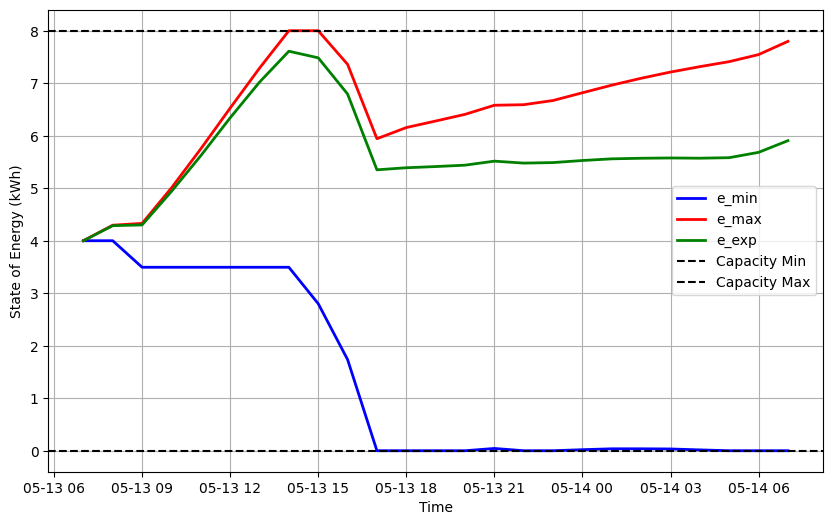

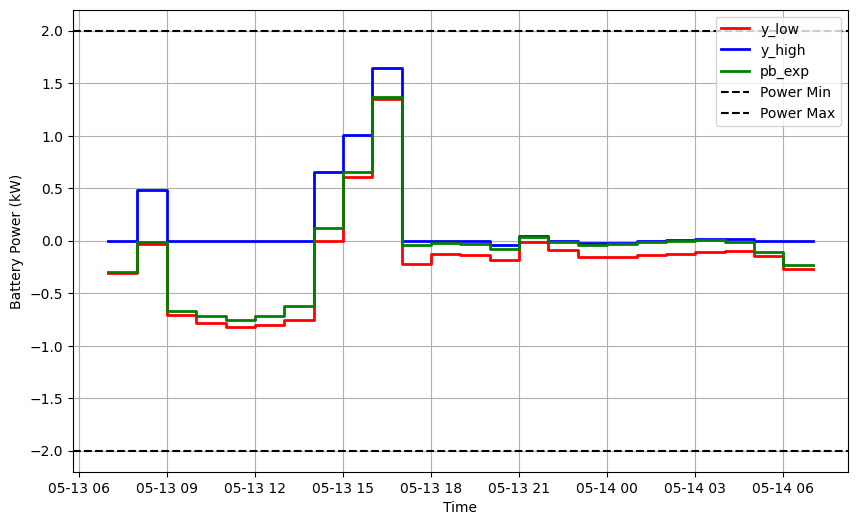

In [51]:
plot_battery_evo(optimizer)
plot_battery_power(optimizer)

In [99]:
time = list(optimizer.model.time)
time.append(time[-1] + pd.Timedelta(minutes=optimizer.mpc_freq))
time

[Timestamp('2020-05-13 15:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 16:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 17:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 18:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 19:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 20:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 21:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 22:00:00+0000', tz='UTC'),
 Timestamp('2020-05-13 23:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 00:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 01:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 02:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 03:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 04:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 05:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 06:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 07:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 08:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 09:00:00+0000', tz='UTC'),
 Timestamp('2020-05-14 10:00:00+0000', tz='UTC'),


In [100]:
y_low = list(optimizer.model.y_low.get_values().values())
y_high = list(optimizer.model.y_high.get_values().values())
pb_exp = list(optimizer.model.pb_exp.get_values().values())

print("y_low:", y_low)
print("y_high:", y_high)
print("pb_exp:", pb_exp)    

#print("Difference betwenn y_low and pb_exp:", np.array(y_low) - np.array(pb_exp))
#print("Difference betwenn y_high and pb_exp:", np.array(y_high) - np.array(pb_exp))

y_low: [1.0820690777619695, 2.205597082737287, -0.18343302794979588, -0.2022274126815952, -0.12065952625268433, -0.13381619310223533, -0.10412590608495911, -0.09886283621214977, -0.0928446011981691, -0.10562485063524761, -0.0939711656997114, -0.09434508594461122, -0.08682423242804158, -0.09321894280705009, -0.1668937801013057, -0.27590128357700866, -0.5010574681733999, -0.6544199138012133, -0.7739545037415348, -1.1084637276291565, -1.0599376773846616, -1.155372799686208, -0.7474150255440106, 0.28067964618040164]
y_high: [1.345565765259033, 2.454434182770177, -2.4121860170433166e-07, -2.830476150970534e-07, 1.5518320360243113e-07, -4.716343972929907e-07, -5.246403523148208e-06, -4.592543493757171e-06, -5.472584051493723e-07, -6.435215891504711e-07, 5.488142200494447e-07, 2.515427375647043e-06, 5.63178283075076e-06, 9.979907696978248e-07, -1.5124563895004017e-08, -3.2976410637392505e-07, -2.8638511810450273e-07, -8.939261956266073e-07, -3.4630047966196395e-06, -0.24768282268154548, -0.23

In [101]:
e_min = list(optimizer.model.e_min.get_values().values())
e_max = list(optimizer.model.e_max.get_values().values())

print("e_min:", e_min)
print("e_max:", e_max)

e_min: [4.0, 2.583614983043207, 5.3377676100713454e-08, 2.3241789296014267e-07, 4.4851181493281547e-07, 2.255317469241237e-07, 6.205960615434866e-07, 5.5665273731632055e-06, 9.890122496228178e-06, 1.035449972516724e-05, 1.0912138858982308e-05, 1.0279075466349994e-05, 7.589319309775172e-06, 1.6220402953032177e-06, 5.216066964889156e-07, 4.5847680684708114e-07, 7.035715710322991e-07, 9.036575261576843e-07, 1.6927163653571145e-06, 4.934081078272339e-06, 0.2353036100313827, 0.4587834194039342, 0.765427653770802, 0.8284202706193997, 1.2140596200832181e-08]
e_max: [4.0, 2.8609799169636445, 0.5392987767338385, 0.7135601452513227, 0.9056761800436678, 1.0203027175363175, 1.1474280898125016, 1.2463476860727474, 1.3402673651466512, 1.4284697199119367, 1.5288133137103999, 1.6180859049565914, 1.7077137205009505, 1.7901967237400451, 1.8787547031006808, 2.037303785327718, 2.299409999489704, 2.775414591480017, 3.3971135075160905, 4.132370284346348, 5.1854108244446095, 6.1923516167500905, 7.28995577535

In [102]:
pg_exp_buy = list(optimizer.model.pg_exp_buy.get_values().values())
pg_exp_sell = list(optimizer.model.pg_exp_sell.get_values().values())

print("pg_exp_buy:", pg_exp_buy)
print("pg_exp_sell:", pg_exp_sell)

pg_exp_buy: [0.042309334827211116, 0.03852120038301322, 0.5451914192104711, 0.4371414161190483, 0.3515032503733947, 0.2975364977719188, 0.2388886427678747, 0.27766351229322034, 0.3161792118269728, 0.3755441958399058, 0.5010397281276935, 0.48606135676166506, 0.4473831503743185, 0.29249539865017127, 0.18904816116535322, 0.1271451989389245, 0.10696133881030437, 0.11034822954464865, 0.05603473282051599, 0.06638749250274716, 0.12561980237832887, 0.12061601473200056, 0.10947963061194649, 0.09699737267577951]
pg_exp_sell: [-1.657637184326958, -2.001710202458255, -0.07561401487328831, -0.101159990091076, -0.09557570600313157, -0.06480230380843591, -0.08500901000076846, -0.06877199372834353, -0.022972260496848435, -0.017239645013557445, -0.009082307622721213, -0.00798271488740763, -0.009193782709093655, -0.041158449199235066, -0.2644225989528365, -0.882740969502811, -1.51674168858009, -2.272502090443414, -2.552308316809378, -2.497935224131383, -2.4741504941538186, -2.2329504793562944, -1.878576

In [103]:
# plot the pdf using the pdf_weights
#time_to_plot = [pd.Timestamp(t) for t in [start_time]]
time_to_plot = [pd.Timestamp(t) for t in optimizer.model.time]
pdf_weights = dict(optimizer.model.pdf_weights)

pdf = pdf_formula(config['forecasts']['parametric_assumption'])

pdf_dist = []

x = np.linspace(-15, 15, 2000)  # Adjust the range as needed
x_total = []
for t in time_to_plot:
    weights = pdf_weights[t]

    y = []
    x_new = []
    for xi in x:
        yi = pdf(xi, *weights)
        y.append(yi)
        x_new.append(xi)

    pdf_dist.append(y)
    x_total.append(x_new)

fig = go.Figure()

for i, t in enumerate(time_to_plot):
    fig.add_trace(go.Scatter(x=x_total[i], y=pdf_dist[i], mode='lines', name=f'Time {t.strftime('%H:%M %d-%m-%Y')}'))

fig.update_layout(
    title='PDFs',
    xaxis_title='Prosumption (kW)',
    yaxis_title='Probability Density',
    legend_title='Time',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-10, 10]),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-0.2, 1]),
    legend_title_text='Timesteps',
    width=1200, 
    height=600,
    showlegend=True,
)



fig.show()

In [104]:
# get forecast widths
# Get the 25% and 75% quantiles of the distributions using their cdfs

cdf = cdf_formula(config['forecasts']['parametric_assumption'])

quantile_probs = [0.25, 0.75]
quantile_values = {}
samples = np.linspace(-8, 8, 10000) # TODO: Code dynamic bounds

for t in pdf_weights.keys():
    weights = pdf_weights[t]
    quantile_values[t] = {}

    # try some values and remember the values right before and after the quantile probabilities
    for prob in quantile_probs:

        for i, sample in enumerate(samples):
            cdf_val = cdf(sample, *weights)
            if cdf_val >= prob:
                quantile_values[t][prob] = [i-1, samples[i-1], cdf(samples[i-1], *weights), i, sample, cdf_val]  # Store the index, cdf value, and sample value just before the quantile

                break
# TODO: Later on interpolate to get the exact quantile value

# For now, only take the first value for the calculation of the width
quantile_approximations = {}
for t, values in quantile_values.items():
    quantile_approximations[t] = values[0.75][1] - values[0.25][1]  # Take the value just before the quantile

In [105]:
quantile_approximations = pd.Series(quantile_approximations, name='quantile_widths')
quantile_approximations

2020-05-13 15:00:00+00:00    1.121712
2020-05-13 16:00:00+00:00    1.059306
2020-05-13 17:00:00+00:00    0.780878
2020-05-13 18:00:00+00:00    0.860886
2020-05-13 19:00:00+00:00    0.513651
2020-05-13 20:00:00+00:00    0.569657
2020-05-13 21:00:00+00:00    0.443244
2020-05-13 22:00:00+00:00    0.420842
2020-05-13 23:00:00+00:00    0.395240
2020-05-14 00:00:00+00:00    0.449645
2020-05-14 01:00:00+00:00    0.400040
2020-05-14 02:00:00+00:00    0.401640
2020-05-14 03:00:00+00:00    0.369637
2020-05-14 04:00:00+00:00    0.396840
2020-05-14 05:00:00+00:00    0.710471
2020-05-14 06:00:00+00:00    1.174517
2020-05-14 07:00:00+00:00    2.133013
2020-05-14 08:00:00+00:00    2.785879
2020-05-14 09:00:00+00:00    3.294729
2020-05-14 10:00:00+00:00    3.664366
2020-05-14 11:00:00+00:00    3.510751
2020-05-14 12:00:00+00:00    3.544354
2020-05-14 13:00:00+00:00    2.899490
2020-05-14 14:00:00+00:00    2.155416
Name: quantile_widths, dtype: float64

In [106]:
battery_limit = config['battery']['capacity_max'] - config['battery']['capacity_min']
scale_factor = battery_limit / quantile_approximations.sum()
widths = quantile_approximations * scale_factor
print("Quantile Widths (scaled):", widths)

Quantile Widths (scaled): 2020-05-13 15:00:00+00:00    0.263497
2020-05-13 16:00:00+00:00    0.248837
2020-05-13 17:00:00+00:00    0.183433
2020-05-13 18:00:00+00:00    0.202227
2020-05-13 19:00:00+00:00    0.120660
2020-05-13 20:00:00+00:00    0.133816
2020-05-13 21:00:00+00:00    0.104121
2020-05-13 22:00:00+00:00    0.098858
2020-05-13 23:00:00+00:00    0.092844
2020-05-14 00:00:00+00:00    0.105624
2020-05-14 01:00:00+00:00    0.093972
2020-05-14 02:00:00+00:00    0.094348
2020-05-14 03:00:00+00:00    0.086830
2020-05-14 04:00:00+00:00    0.093220
2020-05-14 05:00:00+00:00    0.166894
2020-05-14 06:00:00+00:00    0.275901
2020-05-14 07:00:00+00:00    0.501057
2020-05-14 08:00:00+00:00    0.654419
2020-05-14 09:00:00+00:00    0.773951
2020-05-14 10:00:00+00:00    0.860781
2020-05-14 11:00:00+00:00    0.824696
2020-05-14 12:00:00+00:00    0.832589
2020-05-14 13:00:00+00:00    0.681107
2020-05-14 14:00:00+00:00    0.506320
Name: quantile_widths, dtype: float64


In [107]:
type(widths)

pandas.core.series.Series

In [108]:
widths_test = [0.5, 1.0, 1.0, 2.0, 5.0, 2.0, 0.5, 0.5]
omega_sum = 8.0 - 0.0

scale_factor = omega_sum / sum(widths_test)
widths_test = [w * scale_factor for w in widths_test]  # Scale the widths to sum to omega_sum
print("widths_test:", widths_test, "sum:", sum(widths_test), "scale_factor:", scale_factor)


widths_test: [0.32, 0.64, 0.64, 1.28, 3.2, 1.28, 0.32, 0.32] sum: 8.0 scale_factor: 0.64
